# Pastas Recharge Models Comparison

Author: *Martin Vonk*

Based on the case study: *Wateroverlast Raam Vervolgonderzoek Oppervlaktewater Definitief rapport* by Raoul Collenteur, Artesia 2017

From the introduction:

In de zomer van 2017 is door Artesia tijdreeksanalyse uitgevoerd op de stijghoogte meetreeksen in het district Raam (Artesia, 2017). Daarbij is de relatie tussen de grondwaterstanden en verschillende verklarende variabelen bepaald. Uit dit onderzoek is naar voren gekomen dat een groot deel van de variatie in de grondwaterstanden kan worden verklaard door neerslag en verdamping. In de omgeving van de onttrekkingen Vierlingsbeek en Boxmeer moeten echter ook deze grondwateronttrekkingen als verklarende tijdreeksen worden meegenomen. Tot slot is geconcludeerd dat de waterstand van de Maas en andere oppervlaktewaterstanden een groot effect kunnen hebben op de lokale grondwaterstanden.

In [1]:
import numpy as np
import pandas as pd
import pastas as ps
import scipy.io as sc
import matplotlib.pyplot as plt

# Load Data from Raam

In [3]:
# Waterlevel River Maas
ws_maas = ps.read_waterbase("C:/Users/vonkm/Documents/MScThesis/Data/Boxmeer/20170621_006.csv", kind="waterlevel")
ws_sambeek = ps.TimeSeries(ws_maas[-2].series['1950-01-02 00:00:00':].resample('D').mean()*1e-2)

INFO: User provided frequency for time series Gennep: freq=10min
INFO: Time Series Gennep: 2433772 nan-value(s) was/were found and filled with: interpolate.
INFO: User provided frequency for time series Sambeek beneden: freq=10min
INFO: Time Series Sambeek beneden: 3156239 nan-value(s) was/were found and filled with: interpolate.
INFO: User provided frequency for time series Well Dorp: freq=10min
INFO: User provided frequency for time series Grave boven: freq=10min
INFO: Time Series Grave boven: 2435741 nan-value(s) was/were found and filled with: interpolate.
INFO: User provided frequency for time series Beugen: freq=10min
INFO: Time Series Beugen: 269984 nan-value(s) was/were found and filled with: interpolate.
INFO: User provided frequency for time series Boxmeer: freq=10min
INFO: Time Series Boxmeer: 1627483 nan-value(s) was/were found and filled with: interpolate.
INFO: User provided frequency for time series Mook haven: freq=10min
INFO: Time Series Mook haven: 86944 nan-value(s) 

In [4]:
# KNMI Precipitation & Evaporation
knmi = sc.loadmat("C:/Users/vonkm/Documents/MScThesis/Data/Boxmeer/leesKnmiRaam.mat", squeeze_me=True, struct_as_record=False, chars_as_strings=True)

prec = []
for H in knmi["knmiN"]:
    name = H.NAME + "_N"
    x, y = H.x, H.y
    metadata = {"x": x, "y": y}
    tindex = [ps.utils.datenum_to_datetime(tval) for tval in H.RD[:, 0]]
    series = pd.Series(H.RD[:, 1], index=tindex, name=name)
    series.index = series.index.round("D")
    prec.append(ps.TimeSeries(series, freq="D", freq_original="D"))

evap = []
for H in knmi["knmi"]:
    name = H.NAME + "_E"
    x, y = H.x, H.y
    metadata = {"x": x, "y": y}
    tindex = [ps.utils.datenum_to_datetime(tval) for tval in H.EV24[:, 0]]
    series = pd.Series(H.EV24[:, 1], index=tindex, name=name)
    series.index = series.index.round("D")
    evap.append(ps.TimeSeries(series, freq="D", freq_original="D"))

INFO: User provided frequency for time series Arcen_N: freq=D
INFO: Time Series Arcen_N: 1 nan-value(s) was/were found and filled with: interpolate.
INFO: User provided frequency for time series Heumen_N: freq=D
INFO: Time Series Heumen_N: 1 nan-value(s) was/were found and filled with: interpolate.
INFO: User provided frequency for time series IjsselsteynL_N: freq=D
INFO: Time Series IjsselsteynL_N: 1 nan-value(s) was/were found and filled with: interpolate.
INFO: User provided frequency for time series Megen_N: freq=D
INFO: Time Series Megen_N: 1 nan-value(s) was/were found and filled with: interpolate.
INFO: User provided frequency for time series Mill_N: freq=D
INFO: Time Series Mill_N: 1 nan-value(s) was/were found and filled with: interpolate.
INFO: User provided frequency for time series Oss_N: freq=D
INFO: Time Series Oss_N: 1 nan-value(s) was/were found and filled with: interpolate.
INFO: User provided frequency for time series Siebengewald_N: freq=D
INFO: Time Series Siebengew

In [5]:
# Groundwater Levels
men = sc.loadmat("C:/Users/vonkm/Documents/MScThesis/Data/Boxmeer/grwoverlastRaam_schoon.men", squeeze_me=True, struct_as_record=False, chars_as_strings=True)

oseries = []
for H in men["H"]:
    name = H.NITGCode + "_" + str(H.filtnr)
    metadata = { "x": H.xcoord, "y": H.ycoord, "z": np.mean([H.upfiltlev,H.lowfiltlev])}
    tindex = [ps.utils.datenum_to_datetime(tval) for tval in H.values[:, 0]]
    series = pd.Series(H.values[:, 1], index=tindex, name=name)
    oseries.append(series)

In [6]:
# Pumping Wells
fname = 'C:/Users/vonkm/Documents/MScThesis/Data/Boxmeer/menyanthes_invoer_jan17.men'
mat = sc.loadmat(fname, struct_as_record=False, squeeze_me=True, chars_as_strings=True)

well = []
for H in mat['IN']:
    key = H.name
    if key in ["Onttrekking (Boxmeer)", "Onttrekking (Vierlingsbeek)"]:
        key = key.replace(" (", "_")
        key = key.replace(")", "")
        tindex = [ps.utils.datenum_to_datetime(tval) for tval in H.values[:, 0]]
        series = pd.Series(H.values[:, 1], index=tindex)
        metadata = {"x": H.xcoord, "y": H.ycoord}
        well.append(ps.TimeSeries(series, name=key, metadata=metadata, settings="well"))

INFO: Inferred frequency for time series Onttrekking_Boxmeer: freq=MS
INFO: Inferred frequency for time series Onttrekking_Vierlingsbeek: freq=MS


In [7]:
# Surface Waterlevels
data = pd.read_csv("C:/Users/vonkm/Documents/MScThesis/Data/Boxmeer/owaterstanden_Raam.csv", skiprows=140, usecols=["LOCATIE", "PEIL DATUM TIJD", "STAND (NAP)"], parse_dates=True, index_col="LOCATIE")
data1 = pd.read_csv("C:/Users/vonkm/Documents/MScThesis/Data/Boxmeer/owaterstanden_Raam.csv", skiprows=6, nrows=132, index_col="LOCATIE", usecols=["LOCATIE", "X COORDINAAT", "Y COORDINAAT"])

waterlevels = []
for key in np.unique(data.index):
    series = pd.Series(data.loc[key, "STAND (NAP)"].values*1e-2, pd.to_datetime(data.loc[key, "PEIL DATUM TIJD"].values))
    metadata = {"x": data1.loc[key, "X COORDINAAT"], "y": data1.loc[key, "Y COORDINAAT"]}
    waterlevels.append(series)

# Data Around Obs. Well B52B0389_1

In [8]:
for i in range(len(oseries)):
    if oseries[i].name == 'B52B0389_1':
        ho_orig = oseries[i]

In [9]:
index = ps.utils.get_sample(ho_orig.index, ho_orig.asfreq('14d').index)
ho = ho_orig[index]

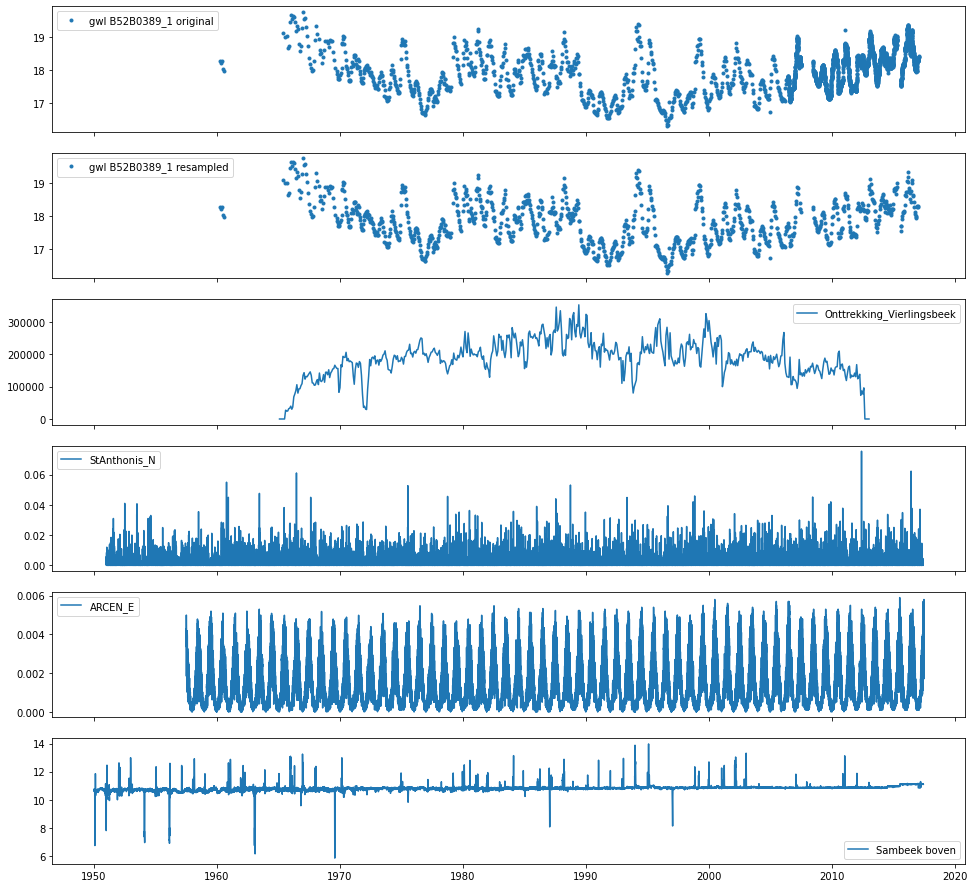

In [10]:
fig, ax = plt.subplots(nrows=6, ncols=1, sharex=True)
fig.set_size_inches(13.5, 12.5)
fig.tight_layout()

ax[0].plot(ho_orig.index, ho_orig, '.', label=f'gwl {ho_orig.name} original')
ax[1].plot(ho.index, ho, '.', label=f'gwl {ho.name} resampled')
ax[2].plot(well[1].series.index, well[1].series, label=well[1].name)
ax[3].plot(prec[-3].series.index, prec[-3].series, label=prec[-3].name)
ax[4].plot(evap[1].series.index, evap[1].series, label=evap[1].name)
ax[5].plot(ws_sambeek.series.index, ws_sambeek.series, label=ws_sambeek.name)

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend();

# Results

## Pastas Results from Collenteur in 2017

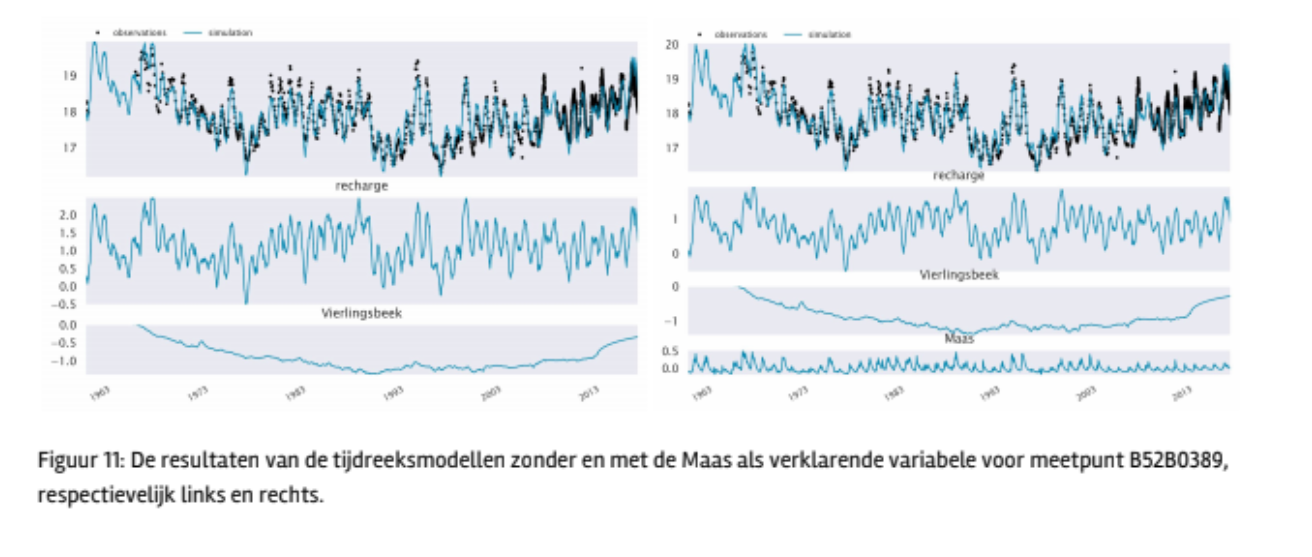

## Pastas with seperate stress models

In [11]:
# ml1 = ps.Model(ho)
# sm1 = ps.StressModel(prec[-3], ps.Gamma, name='prec_anthonis', up=True, settings='prec')
# sm2 = ps.StressModel(evap[1], ps.Gamma, name='evap_arcen', up=False, settings='evap')
# sm3 = ps.StressModel(ws_sambeek, ps.Gamma, name='maas_sambeek')
# sm4 = ps.StressModel(well[1], ps.Hantush, name='well_vierlingsbeek', settings='well')
# ml1.add_stressmodel([sm1,sm2,sm3,sm4])
# ml1.solve(noise=True)

In [12]:
# ml1.plots.decomposition();

## Pastas with linear recharge model

In [13]:
ml2 = ps.Model(ho)
sm1 = ps.RechargeModel(prec[-3], evap[1], ps.Gamma, name='rech')
sm2 = ps.StressModel(ws_sambeek, ps.Polder, name='maas_sambeek')
sm3 = ps.StressModel(well[1], ps.Hantush, name='well_vierlingsbeek', settings='well', up=False)
ml2.add_stressmodel([sm1,sm2,sm3])
ml2.solve(noise=True)

INFO: Cannot determine frequency of series B52B0389_1: freq=None. The time series is irregular.
INFO: Time Series B52B0389_1: 18 nan-value(s) was/were found and filled with: drop.
INFO: Time Series Onttrekking_Vierlingsbeek were sampled up using bfill.
INFO: Time Series StAnthonis_N was extended to 1950-04-18 00:00:00 with the mean value of the time series.
INFO: Time Series ARCEN_E was extended to 1950-04-18 00:00:00 with the mean value of the time series.
INFO: Time Series Onttrekking_Vierlingsbeek were sampled up using bfill.
INFO: Time Series Onttrekking_Vierlingsbeek was extended to 1950-04-18 00:00:00 by adding 0.0 values.
INFO: Time Series Onttrekking_Vierlingsbeek was extended to 2017-01-06 00:00:00 by adding 0.0 values.


Fit report B52B0389_1                         Fit Statistics
nfev     58                     EVP                       86.50
nobs     1172                   R2                         0.86
noise    True                   RMSE                       0.24
tmin     1960-04-15 00:00:00    AIC                       15.63
tmax     2017-01-06 00:00:00    BIC                       76.43
freq     D                      Obj                        6.01
warmup   3650 days 00:00:00     ___                            
solver   LeastSquares           Interpolated                 No

Parameters (12 were optimized)
                          optimal     stderr      initial  vary
rech_A                    1413.69     ±7.67%       210.78  True
rech_n                    1.24629     ±1.94%            1  True
rech_a                    214.152     ±9.40%           10  True
rech_f                  -0.965556     ±6.54%           -1  True
maas_sambeek_A           0.250735    ±46.15%            1  True
maas_sambee

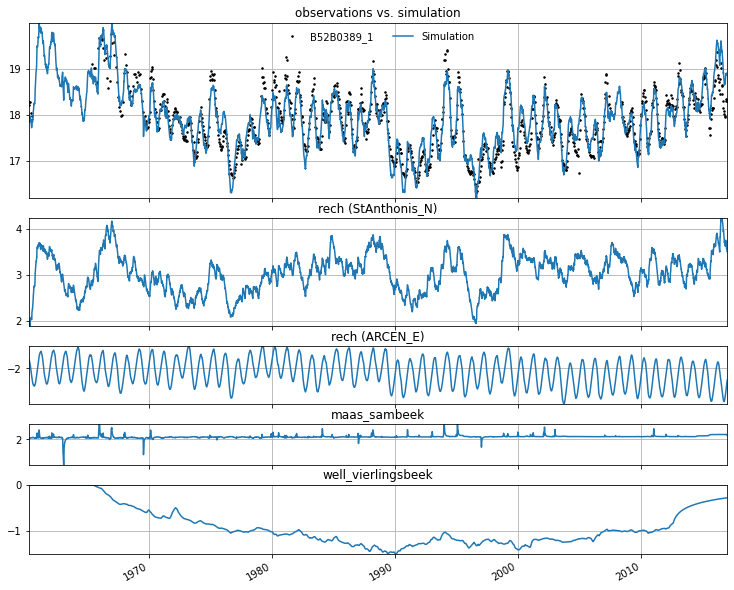

In [14]:
ml2.plots.decomposition();

## Pastas with Non-Linear Recharge Model - Berendrecht

In [14]:
ml3 = ps.Model(ho)
sm1 = ps.RechargeModel(prec[-3], evap[1], ps.Gamma, recharge=ps.rch.Berendrecht(), name='rech')
sm2 = ps.StressModel(ws_sambeek, ps.Gamma, name='maas_sambeek')
sm3 = ps.StressModel(well[1], ps.Hantush, name='well_vierlingsbeek', settings='well', up=False)
ml3.add_stressmodel([sm1,sm2,sm3])
ml3.solve(noise=True)

INFO: Cannot determine frequency of series B52B0389_1: freq=None. The time series is irregular.
INFO: Time Series B52B0389_1: 18 nan-value(s) was/were found and filled with: drop.
INFO: Time Series Onttrekking_Vierlingsbeek were sampled up using bfill.
INFO: Time Series StAnthonis_N was extended to 1950-04-18 00:00:00 with the mean value of the time series.
INFO: Time Series ARCEN_E was extended to 1950-04-18 00:00:00 with the mean value of the time series.
INFO: Time Series Onttrekking_Vierlingsbeek were sampled up using bfill.
INFO: Time Series Onttrekking_Vierlingsbeek was extended to 1950-04-18 00:00:00 by adding 0.0 values.
INFO: Time Series Onttrekking_Vierlingsbeek was extended to 2017-01-06 00:00:00 by adding 0.0 values.


Fit report B52B0389_1                        Fit Statistics
nfev     62                     EVP                      77.50
nobs     1172                   R2                        0.77
noise    True                   RMSE                      0.31
tmin     1960-04-15 00:00:00    AIC                      26.58
tmax     2017-01-06 00:00:00    BIC                     117.78
freq     D                      Obj                       5.95
warmup   3650 days 00:00:00     ___                           
solver   LeastSquares           Interpolated                No

Parameters (14 were optimized)
                          optimal    stderr     initial   vary
rech_A                1927.042981    ±7.23%   54.192626   True
rech_n                   0.306271   ±10.64%    1.000000   True
rech_a                  69.737496   ±44.14%   10.000000   True
rech_fi                  0.900000     ±nan%    0.900000  False
rech_fc                  1.000000     ±nan%    1.000000  False
rech_sr                  0

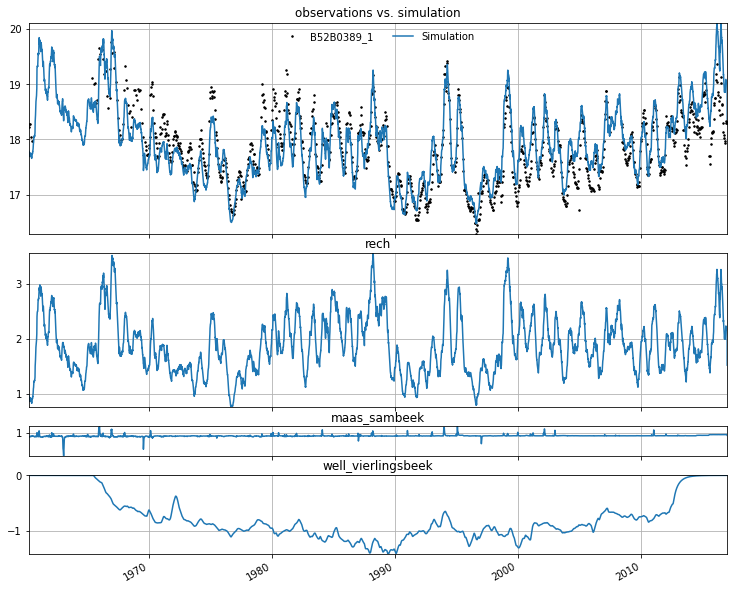

In [15]:
ml3.plots.decomposition();

## Pastas with Non-Linear Recharge Model - FlexModel

In [16]:
ml4 = ps.Model(ho)
sm1 = ps.RechargeModel(prec[-3], evap[1], ps.Gamma, recharge=ps.rch.FlexModel(), name='rech')
sm2 = ps.StressModel(ws_sambeek, ps.Gamma, name='maas_sambeek') #other timeseries for the maas
sm3 = ps.StressModel(well[1], ps.Hantush, name='well_vierlingsbeek', settings='well', up=False) #distance=4000, 
ml4.add_stressmodel([sm1,sm2,sm3])
ml4.solve(noise=True)

INFO: Cannot determine frequency of series B52B0389_1: freq=None. The time series is irregular.
INFO: Time Series B52B0389_1: 18 nan-value(s) was/were found and filled with: drop.
INFO: Time Series Onttrekking_Vierlingsbeek were sampled up using bfill.
INFO: Time Series StAnthonis_N was extended to 1950-04-18 00:00:00 with the mean value of the time series.
INFO: Time Series ARCEN_E was extended to 1950-04-18 00:00:00 with the mean value of the time series.
INFO: Time Series Onttrekking_Vierlingsbeek were sampled up using bfill.
INFO: Time Series Onttrekking_Vierlingsbeek was extended to 1950-04-18 00:00:00 by adding 0.0 values.
INFO: Time Series Onttrekking_Vierlingsbeek was extended to 2017-01-06 00:00:00 by adding 0.0 values.


Fit report B52B0389_1                        Fit Statistics
nfev     49                     EVP                      53.66
nobs     1172                   R2                        0.53
noise    True                   RMSE                      0.44
tmin     1960-04-15 00:00:00    AIC                      23.15
tmax     2017-01-06 00:00:00    BIC                     109.28
freq     D                      Obj                       7.52
warmup   3650 days 00:00:00     ___                           
solver   LeastSquares           Interpolated                No

Parameters (14 were optimized)
                         optimal     stderr     initial   vary
rech_A                764.542146    ±10.98%   11.474959   True
rech_n                  0.100002    ±33.62%    1.000000   True
rech_a                 95.804594   ±248.53%   10.000000   True
rech_srmax            428.255707  ±4093.18%  250.000000   True
rech_lp                 0.250000      ±nan%    0.250000  False
rech_ks               864.

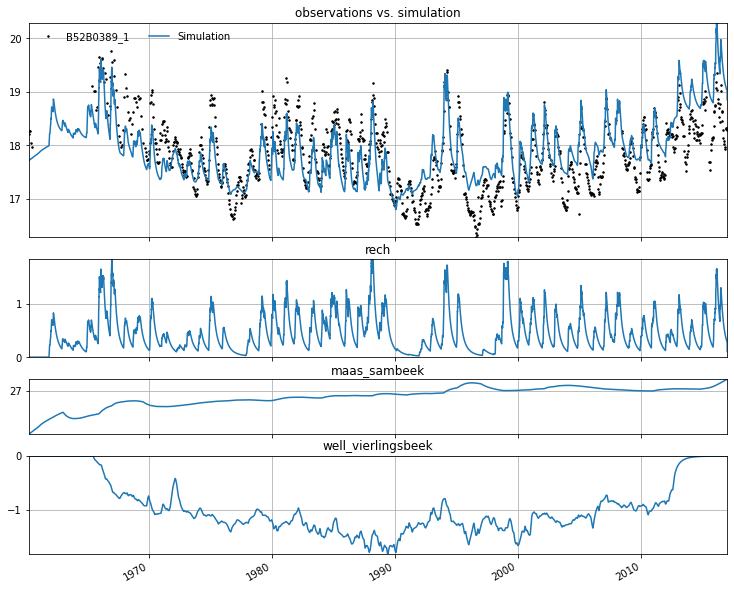

In [17]:
ml4.plots.decomposition();

## Recharge Comparison

In [18]:
P = np.array(prec[-3].series['1957-07-02':'2017-05-30'])
E = np.array(evap[1].series['1957-07-02':'2017-05-30'])
idx = prec[-3].series['1957-07-02':'2017-05-30'].index

In [19]:
R_lin = P+ml2.get_parameters()[3]*E

In [20]:
p_ml3 = ml3.get_parameters()
R_ber, S_ber, Ea_ber, Pe_ber = ps.rch.Berendrecht.get_recharge(P, E, fi=p_ml3[3], fc=p_ml3[4], sr=p_ml3[5], de=p_ml3[6], l=p_ml3[7], m=p_ml3[8], ks=p_ml3[9], dt=1.0)

In [21]:
p_ml4 = ml4.get_parameters()
R_fl, Ea_fl, Ei_fl, Pe_fl, Su_fl, Si_fl = ps.rch.FlexModel.get_recharge(P, E, srmax=p_ml4[3], lp=p_ml4[4], ks=p_ml4[5], gamma=p_ml4[6], simax=p_ml4[7], kv=p_ml4[8], dt=1.0)

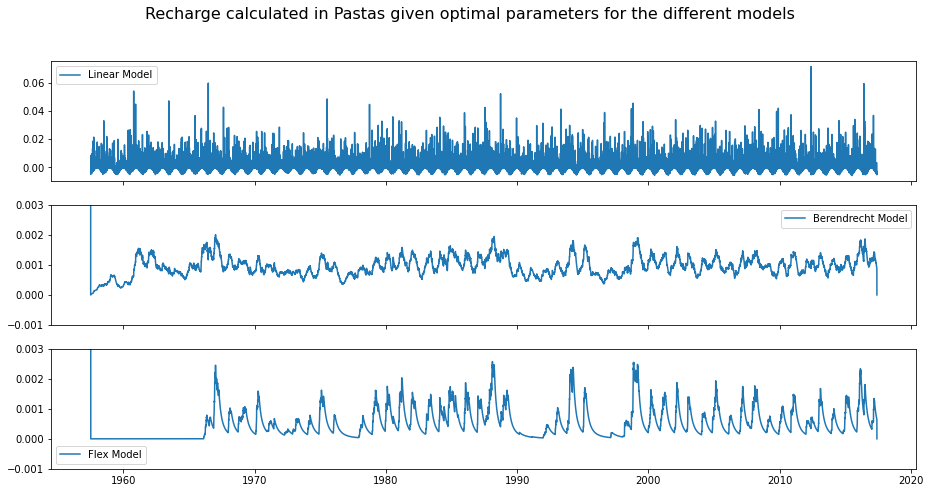

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)
fig.suptitle('Recharge calculated in Pastas given optimal parameters for the different models', fontsize=16)
fig.set_size_inches(15.5, 7.5)
ax[0].plot(idx, R_lin, label='Linear Model')
ax[0].legend()
ax[1].plot(idx, R_ber, label='Berendrecht Model')
ax[1].legend()
ax[1].set_ylim([-0.001,.003])
ax[2].plot(idx, R_fl, label='Flex Model')
ax[2].legend()
ax[2].set_ylim([-0.001,.003]);